In [62]:
from numpy import *
import matplotlib.pyplot as plt 
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import preprocessing
import pandas as pd

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
#df = pd.read_csv("NoSqli_Dataset.csv")
df = pd.read_csv("/content/drive/MyDrive/Thesis Resources/dataset/NoSql_Injection/NoSqli_Dataset.csv")
df.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,ClassLabel
0,0,0,0,1,1,0,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [65]:

X = df.drop(['ClassLabel'],axis='columns')
Y = df['ClassLabel']

In [66]:
Y.value_counts()

0    801
1    203
Name: ClassLabel, dtype: int64

In [67]:
X.head(2)

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9
0,0,0,0,1,1,0,0,0,0,0
1,1,1,0,1,0,0,0,0,0,0


In [68]:
Y.head(5)

0    0
1    1
2    0
3    0
4    0
Name: ClassLabel, dtype: int64

# Evaluation of Best Classification Model Using GridSearchCV(with handling imbalanced data)

In [69]:
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',class_weight='balanced'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear','poly']
        }  
    },
    'decision_tree': {
        'model': tree.DecisionTreeClassifier(class_weight='balanced'),
        'params' : {
            'criterion':["gini","entropy"],
            'max_depth':[1,2,3,4,5,6,7,None]
        }
    },
    'Adaboost':{
        'model':AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(random_state = 11, max_features = "auto",max_depth = None,class_weight='balanced')),
        'params':{
              'base_estimator__criterion' : ["gini", "entropy"],
              'base_estimator__splitter' :   ["best", "random"],
              'n_estimators': [1, 2]
             }
    },

    'random_forest': {
        'model': RandomForestClassifier(class_weight = 'balanced'),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto',class_weight = 'balanced'),
        'params': {
            'C': [1,5,10]
        }
    },
    'Naive_Bayes:BernoulliNB':{
        'model':BernoulliNB(),
        'params':{
            'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
        }
    },
}

In [70]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import ClusterCentroids,NearMiss, RandomUnderSampler
from imblearn.combine import SMOTEENN,SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV



#this method should be updated with more ML models
def benchmark(sampling_type,x,y):
    #lr = LogisticRegression(penalty = 'l2')
    #param_grid = {'C':[0.01,0.1,1,10]}
    scores = []

    target_names = ['Not Malicious', 'Malicious']
    ConfusionMatrix={}

    for model_name, mp in model_params.items():
        grid =  GridSearchCV(estimator=mp['model'],param_grid= mp['params'],scoring='accuracy', cv=10,n_jobs=-1,verbose=2)
        grid = grid.fit(x, y)
        y_pred=grid.best_estimator_.predict(x)
        print('-------------------------------------------')
        print(model_name.upper())  
        print('-------------------------------------------')
        report=classification_report(y, y_pred, target_names=target_names,output_dict=True)
        print(report)
        ConfusionMatrix[model_name]  =  confusion_matrix(y, y_pred)
        
        macro_precision =  report['macro avg']['precision'] 
        macro_recall = report['macro avg']['recall']    
        macro_f1 = report['macro avg']['f1-score']    
        accuracy = report['accuracy']

        
        # print("precision: ")
        # print(macro_precision)
        # print("recall: ")
        # print(macro_recall)
        # print("f1-score: ")
        # print(macro_f1)
        # print("accuracy: ")
        # print(accuracy)
      
        
        scores.append({
            'sampling_type':sampling_type,
            'model': model_name.upper(),
            'best_score': grid.best_score_,
            'precision':macro_precision,
            'recall':macro_recall,
            'f1_score':macro_f1,
            'best_params': grid.best_params_,    
        })
    
        #gs = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=10, verbose=2)
        #gs = gs.fit(X.values,Y.values.ravel())
    return scores

def transform(transformer,X,Y):
    print("Transforming {}".format(transformer.__class__.__name__))
    X_resampled,Y_resampled = transformer.fit_sample(X.values,Y.values.ravel())
    return transformer.__class__.__name__,pd.DataFrame(X_resampled), pd.DataFrame(Y_resampled)

Apply transformations to dataset

In [71]:
datasets = []
datasets.append(("base",X,Y))
datasets.append(transform(SMOTE(n_jobs=-1),X,Y))
datasets.append(transform(RandomOverSampler(),X,Y))
datasets.append(transform(NearMiss(n_jobs=-1),X,Y))
datasets.append(transform(RandomUnderSampler(),X,Y))
datasets.append(transform(SMOTEENN(),X,Y))
datasets.append(transform(SMOTETomek(),X,Y))

Transforming SMOTE
Transforming RandomOverSampler
Transforming NearMiss


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Transforming RandomUnderSampler
Transforming SMOTEENN
Transforming SMOTETomek


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Determine best hyperparameters

In [72]:
benchmark_scores = []
for sample_type,X,Y in datasets:
    print('______________________________________________________________')
    print('{}'.format(sample_type))
    benchmark_scores = benchmark_scores+ (benchmark(sample_type,X,Y))
    print('______________________________________________________________')



______________________________________________________________
base
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9634300126103404, 'recall': 0.9538077403245943, 'f1-score': 0.958594730238394, 'support': 801}, 'Malicious': {'precision': 0.8246445497630331, 'recall': 0.8571428571428571, 'f1-score': 0.8405797101449276, 'support': 203}, 'accuracy': 0.9342629482071713, 'macro avg': {'precision': 0.8940372811866868, 'recall': 0.9054752987337257, 'f1-score': 0.8995872201916608, 'support': 1004}, 'weighted avg': {'precision': 0.9353688084689028, 'recall': 0.9342629482071713, 'f1-score': 0.9347331275700935, 'support': 1004}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.9698162729658792, 'recall': 0.9225967540574282, 'f1-score': 0.945617402431222, 'support': 801}, 'Malicious': {'precision': 0.743801652892562, 'recall': 0.8866995073891626, 'f1-score': 0.8089887640449438, 'support': 203}, 'accuracy': 0.9153386454183267, 'macro avg': {'precision': 0.8568089629292206, 'recall': 0.9046481307232954, 'f1-score': 0.8773030832380829, 'support': 1004}, 'weighted avg': {'precision': 0.9241180977916926, 'recall': 0.9153386454183267, 'f1-score': 0.917992289291367, 'support': 1004}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9695817490494296, 'recall': 0.9550561797752809, 'f1-score': 0.9622641509433961, 'support': 801}, 'Malicious': {'precision': 0.8325581395348837, 'recall': 0.8817733990147784, 'f1-score': 0.8564593301435407, 'support': 203}, 'accuracy': 0.9402390438247012, 'macro avg': {'precision': 0.9010699442921566, 'recall': 0.9184147893950296, 'f1-score': 0.9093617405434684, 'support': 1004}, 'weighted avg': {'precision': 0.9418767762093372, 'recall': 0.9402390438247012, 'f1-score': 0.9408713435505967, 'support': 1004}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9695817490494296, 'recall': 0.9550561797752809, 'f1-score': 0.9622641509433961, 'support': 801}, 'Malicious': {'precision': 0.8325581395348837, 'recall': 0.8817733990147784, 'f1-score': 0.8564593301435407, 'support': 203}, 'accuracy': 0.9402390438247012, 'macro avg': {'precision': 0.9010699442921566, 'recall': 0.9184147893950296, 'f1-score': 0.9093617405434684, 'support': 1004}, 'weighted avg': {'precision': 0.9418767762093372, 'recall': 0.9402390438247012, 'f1-score': 0.9408713435505967, 'support': 1004}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9730458221024259, 'recall': 0.9013732833957553, 'f1-score': 0.9358392741412831, 'support': 801}, 'Malicious': {'precision': 0.6984732824427481, 'reca

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9459459459459459, 'recall': 0.9612983770287141, 'f1-score': 0.9535603715170278, 'support': 801}, 'Malicious': {'precision': 0.8368421052631579, 'recall': 0.7832512315270936, 'f1-score': 0.8091603053435116, 'support': 203}, 'accuracy': 0.9252988047808764, 'macro avg': {'precision': 0.8913940256045519, 'recall': 0.8722748042779038, 'f1-score': 0.8813603384302697, 'support': 1004}, 'weighted avg': {'precision': 0.9238861056485296, 'recall': 0.9252988047808764, 'f1-score': 0.9243639437946933, 'support': 1004}}
______________________________________________________________
______________________________________________________________
SMOTE
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.906519065190652, 'recall': 0.920099875156055, 'f1-score': 0.9132589838909542, 'support': 801}, 'Malicious': {'precision': 0.9188846641318125, 'recall': 0.9051186017478152, 'f1-score': 0.9119496855345912, 'support': 801}, 'accuracy': 0.9126092384519351, 'macro avg': {'precision': 0.9127018646612322, 'recall': 0.9126092384519351, 'f1-score': 0.9126043347127727, 'support': 1602}, 'weighted avg': {'precision': 0.9127018646612323, 'recall': 0.9126092384519351, 'f1-score': 0.9126043347127727, 'support': 1602}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.9034229828850856, 'recall': 0.9225967540574282, 'f1-score': 0.9129092032118593, 'support': 801}, 'Malicious': {'precision': 0.9209183673469388, 'recall': 0.9013732833957553, 'f1-score': 0.9110410094637225, 'support': 801}, 'accuracy': 0.9119850187265918, 'macro avg': {'precision': 0.9121706751160121, 'recall': 0.9119850187265918, 'f1-score': 0.9119751063377909, 'support': 1602}, 'weighted avg': {'precision': 0.9121706751160122, 'recall': 0.9119850187265918, 'f1-score': 0.9119751063377909, 'support': 1602}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9067484662576687, 'recall': 0.9225967540574282, 'f1-score': 0.9146039603960398, 'support': 801}, 'Malicious': {'precision': 0.9212198221092758, 'recall': 0.9051186017478152, 'f1-score': 0.9130982367758187, 'support': 801}, 'accuracy': 0.9138576779026217, 'macro avg': {'precision': 0.9139841441834722, 'recall': 0.9138576779026217, 'f1-score': 0.9138510985859292, 'support': 1602}, 'weighted avg': {'precision': 0.9139841441834723, 'recall': 0.9138576779026217, 'f1-score': 0.9138510985859292, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9067484662576687, 'recall': 0.9225967540574282, 'f1-score': 0.9146039603960398, 'support': 801}, 'Malicious': {'precision': 0.9212198221092758, 'recall': 0.9051186017478152, 'f1-score': 0.9130982367758187, 'support': 801}, 'accuracy': 0.9138576779026217, 'macro avg': {'precision': 0.9139841441834722, 'recall': 0.9138576779026217, 'f1-score': 0.9138510985859292, 'support': 1602}, 'weighted avg': {'precision': 0.9139841441834723, 'recall': 0.9138576779026217, 'f1-score': 0.9138510985859292, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.8948019801980198, 'recall': 0.9026217228464419, 'f1-score': 0.8986948415164698, 'support': 801}, 'Malicious': {'precision': 0.9017632241813602, 'reca

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.8623529411764705, 'recall': 0.9151061173533084, 'f1-score': 0.8879466989703211, 'support': 801}, 'Malicious': {'precision': 0.9095744680851063, 'recall': 0.8539325842696629, 'f1-score': 0.8808757244043787, 'support': 801}, 'accuracy': 0.8845193508114857, 'macro avg': {'precision': 0.8859637046307884, 'recall': 0.8845193508114857, 'f1-score': 0.8844112116873499, 'support': 1602}, 'weighted avg': {'precision': 0.8859637046307884, 'recall': 0.8845193508114857, 'f1-score': 0.8844112116873498, 'support': 1602}}
______________________________________________________________
______________________________________________________________
RandomOverSampler
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.92, 'recall': 0.9188514357053683, 'f1-score': 0.919425359150531, 'support': 801}, 'Malicious': {'precision': 0.9189526184538653, 'recall': 0.920099875156055, 'f1-score': 0.9195258889582034, 'support': 801}, 'accuracy': 0.9194756554307116, 'macro avg': {'precision': 0.9194763092269327, 'recall': 0.9194756554307116, 'f1-score': 0.9194756240543672, 'support': 1602}, 'weighted avg': {'precision': 0.9194763092269327, 'recall': 0.9194756554307116, 'f1-score': 0.9194756240543672, 'support': 1602}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.8990267639902676, 'recall': 0.9225967540574282, 'f1-score': 0.9106592729513246, 'support': 801}, 'Malicious': {'precision': 0.9205128205128205, 'recall': 0.8963795255930087, 'f1-score': 0.9082858950031625, 'support': 801}, 'accuracy': 0.9094881398252185, 'macro avg': {'precision': 0.909769792251544, 'recall': 0.9094881398252185, 'f1-score': 0.9094725839772435, 'support': 1602}, 'weighted avg': {'precision': 0.909769792251544, 'recall': 0.9094881398252185, 'f1-score': 0.9094725839772436, 'support': 1602}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.7s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.9202988792029888, 'recall': 0.9225967540574282, 'f1-score': 0.9214463840399003, 'support': 801}, 'Malicious': {'precision': 0.9224030037546934, 'recall': 0.920099875156055, 'f1-score': 0.92125, 'support': 801}, 'accuracy': 0.9213483146067416, 'macro avg': {'precision': 0.9213509414788411, 'recall': 0.9213483146067416, 'f1-score': 0.9213481920199502, 'support': 1602}, 'weighted avg': {'precision': 0.9213509414788412, 'recall': 0.9213483146067416, 'f1-score': 0.9213481920199501, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9202988792029888, 'recall': 0.9225967540574282, 'f1-score': 0.9214463840399003, 'support': 801}, 'Malicious': {'precision': 0.9224030037546934, 'recall': 0.920099875156055, 'f1-score': 0.92125, 'support': 801}, 'accuracy': 0.9213483146067416, 'macro avg': {'precision': 0.9213509414788411, 'recall': 0.9213483146067416, 'f1-score': 0.9213481920199502, 'support': 1602}, 'weighted avg': {'precision': 0.9213509414788412, 'recall': 0.9213483146067416, 'f1-score': 0.9213481920199501, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.904881101376721, 'recall': 0.9026217228464419, 'f1-score': 0.90375, 'support': 801}, 'Malicious': {'precision': 0.9028642590286425, 'recall': 0.9051186017478152, 'f1-score': 0.9039900249376559, 'support': 801}, 'accuracy': 0.9038701622971286, 'macro avg': {'precision': 0.9038726802026817, 'recall': 0.9038701622971286, 'f1-score': 0.9038700124688279, 'support': 1602}, 'weighted avg': {'precision': 0.9038726802026817, 'recall': 0.9038701622971286, 'f1-score': 0.903870012468828, 'support': 1602}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.8751486325802615, 'recall': 0.9188514357053683, 'f1-score': 0.8964677222898904, 'support': 801}, 'Malicious': {'precision': 0.9145860709592641, 'recall': 0.8689138576779026, 'f1-score': 0.8911651728553137, 'support': 801}, 'accuracy': 0.8938826466916354, 'macro avg': {'precision': 0.8948673517697628, 'recall': 0.8938826466916354, 'f1-score': 0.893816447572602, 'support': 1602}, 'weighted avg': {'precision': 0.8948673517697628, 'recall': 0.8938826466916354, 'f1-score': 0.893816447572602, 'support': 1602}}
______________________________________________________________
______________________________________________________________
NearMiss
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.9035532994923858, 'recall': 0.8768472906403941, 'f1-score': 0.89, 'support': 203}, 'Malicious': {'precision': 0.8803827751196173, 'recall': 0.9064039408866995, 'f1-score': 0.8932038834951458, 'support': 203}, 'accuracy': 0.8916256157635468, 'macro avg': {'precision': 0.8919680373060015, 'recall': 0.8916256157635468, 'f1-score': 0.8916019417475729, 'support': 406}, 'weighted avg': {'precision': 0.8919680373060016, 'recall': 0.8916256157635468, 'f1-score': 0.8916019417475729, 'support': 406}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.8598130841121495, 'recall': 0.9064039408866995, 'f1-score': 0.8824940047961631, 'support': 203}, 'Malicious': {'precision': 0.9010416666666666, 'recall': 0.8522167487684729, 'f1-score': 0.8759493670886076, 'support': 203}, 'accuracy': 0.8793103448275862, 'macro avg': {'precision': 0.8804273753894081, 'recall': 0.8793103448275862, 'f1-score': 0.8792216859423854, 'support': 406}, 'weighted avg': {'precision': 0.880427375389408, 'recall': 0.8793103448275862, 'f1-score': 0.8792216859423854, 'support': 406}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.8916256157635468, 'recall': 0.8916256157635468, 'f1-score': 0.8916256157635468, 'support': 203}, 'Malicious': {'precision': 0.8916256157635468, 'recall': 0.8916256157635468, 'f1-score': 0.8916256157635468, 'support': 203}, 'accuracy': 0.8916256157635468, 'macro avg': {'precision': 0.8916256157635468, 'recall': 0.8916256157635468, 'f1-score': 0.8916256157635468, 'support': 406}, 'weighted avg': {'precision': 0.8916256157635468, 'recall': 0.8916256157635468, 'f1-score': 0.8916256157635468, 'support': 406}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9035532994923858, 'recall': 0.8768472906403941, 'f1-score': 0.89, 'support': 203}, 'Malicious': {'precision': 0.8803827751196173, 'recall': 0.9064039408866995, 'f1-score': 0.8932038834951458, 'support': 203}, 'accuracy': 0.8916256157635468, 'macro avg': {'precision': 0.8919680373060015, 'recall': 0.8916256157635468, 'f1-score': 0.8916019417475729, 'support': 406}, 'weighted avg': {'precision': 0.8919680373060016, 'recall': 0.8916256157635468, 'f1-score': 0.8916019417475729, 'support': 406}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.8872549019607843, 'recall': 0.8916256157635468, 'f1-score': 0.8894348894348895, 'support': 203}, 'Malicious': {'precision': 0.8910891089108911, 'recall': 0.886699507

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9243243243243243, 'recall': 0.8423645320197044, 'f1-score': 0.881443298969072, 'support': 203}, 'Malicious': {'precision': 0.8552036199095022, 'recall': 0.9310344827586207, 'f1-score': 0.8915094339622641, 'support': 203}, 'accuracy': 0.8866995073891626, 'macro avg': {'precision': 0.8897639721169133, 'recall': 0.8866995073891626, 'f1-score': 0.8864763664656681, 'support': 406}, 'weighted avg': {'precision': 0.8897639721169134, 'recall': 0.8866995073891626, 'f1-score': 0.8864763664656682, 'support': 406}}
______________________________________________________________
______________________________________________________________
RandomUnderSampler
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.8923766816143498, 'recall': 0.9802955665024631, 'f1-score': 0.9342723004694836, 'support': 203}, 'Malicious': {'precision': 0.9781420765027322, 'recall': 0.8817733990147784, 'f1-score': 0.927461139896373, 'support': 203}, 'accuracy': 0.9310344827586207, 'macro avg': {'precision': 0.9352593790585411, 'recall': 0.9310344827586208, 'f1-score': 0.9308667201829284, 'support': 406}, 'weighted avg': {'precision': 0.935259379058541, 'recall': 0.9310344827586207, 'f1-score': 0.9308667201829283, 'support': 406}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 157 out of 160 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.8928571428571429, 'recall': 0.9852216748768473, 'f1-score': 0.936768149882904, 'support': 203}, 'Malicious': {'precision': 0.9835164835164835, 'recall': 0.8817733990147784, 'f1-score': 0.9298701298701298, 'support': 203}, 'accuracy': 0.9334975369458128, 'macro avg': {'precision': 0.9381868131868132, 'recall': 0.9334975369458128, 'f1-score': 0.9333191398765169, 'support': 406}, 'weighted avg': {'precision': 0.9381868131868132, 'recall': 0.9334975369458128, 'f1-score': 0.9333191398765169, 'support': 406}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.8928571428571429, 'recall': 0.9852216748768473, 'f1-score': 0.936768149882904, 'support': 203}, 'Malicious': {'precision': 0.9835164835164835, 'recall': 0.8817733990147784, 'f1-score': 0.9298701298701298, 'support': 203}, 'accuracy': 0.9334975369458128, 'macro avg': {'precision': 0.9381868131868132, 'recall': 0.9334975369458128, 'f1-score': 0.9333191398765169, 'support': 406}, 'weighted avg': {'precision': 0.9381868131868132, 'recall': 0.9334975369458128, 'f1-score': 0.9333191398765169, 'support': 406}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.9036697247706422, 'recall': 0.9704433497536946, 'f1-score': 0.9358669833729216, 'support': 203}, 'Malicious': {'precision': 0.9680851063829787, 'recall': 0.896551724137931, 'f1-score': 0.9309462915601023, 'support': 203}, 'accuracy': 0.9334975369458128, 'macro avg': {'precision': 0.9358774155768105, 'recall': 0.9334975369458128, 'f1-score': 0.933406637466512, 'support': 406}, 'weighted avg': {'precision': 0.9358774155768105, 'recall': 0.9334975369458128, 'f1-score': 0.9334066374665119, 'support': 406}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9033816425120773, 'recall': 0.9211822660098522, 'f1-score': 0.9121951219512194, 'support': 203}, 'Malicious': {'precision': 0.9195979899497487, 'recall':

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.8738317757009346, 'recall': 0.9211822660098522, 'f1-score': 0.8968824940047961, 'support': 203}, 'Malicious': {'precision': 0.9166666666666666, 'recall': 0.8669950738916257, 'f1-score': 0.8911392405063291, 'support': 203}, 'accuracy': 0.8940886699507389, 'macro avg': {'precision': 0.8952492211838006, 'recall': 0.8940886699507389, 'f1-score': 0.8940108672555627, 'support': 406}, 'weighted avg': {'precision': 0.8952492211838007, 'recall': 0.8940886699507389, 'f1-score': 0.8940108672555627, 'support': 406}}
______________________________________________________________
______________________________________________________________
SMOTEENN
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.0s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 733}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 541}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1274}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1274}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 733}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 541}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1274}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1274}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.5s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 733}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 541}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1274}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1274}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 733}, 'Malicious': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 541}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1274}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1274}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------
{'Not Malicious': {'precision': 0.9918367346938776, 'recall': 0.9945429740791268, 'f1-score': 0.9931880108991826, 'support': 733}, 'Malicious': {'precision': 0.9925788497217068, 'recall': 0.988909426987061, 'f1-score': 0.9907407407407407, 'support': 541}, 'accuracy': 0.9921507064364207, 'macro avg': {'precision': 0.9922077922077922, 'recall': 0.9917262005330939, 'f1-score': 0

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.9593709043250328, 'recall': 0.9986357435197817, 'f1-score': 0.9786096256684492, 'support': 733}, 'Malicious': {'precision': 0.9980430528375733, 'recall': 0.9426987060998152, 'f1-score': 0.9695817490494296, 'support': 541}, 'accuracy': 0.9748822605965463, 'macro avg': {'precision': 0.9787069785813031, 'recall': 0.9706672248097985, 'f1-score': 0.9740956873589395, 'support': 1274}, 'weighted avg': {'precision': 0.9757929077357741, 'recall': 0.9748822605965463, 'f1-score': 0.9747759669157887, 'support': 1274}}
______________________________________________________________
______________________________________________________________
SMOTETomek
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.8907766990291263, 'recall': 0.916354556803995, 'f1-score': 0.9033846153846153, 'support': 801}, 'Malicious': {'precision': 0.9138817480719794, 'recall': 0.8876404494382022, 'f1-score': 0.9005699810006332, 'support': 801}, 'accuracy': 0.9019975031210986, 'macro avg': {'precision': 0.9023292235505529, 'recall': 0.9019975031210986, 'f1-score': 0.9019772981926243, 'support': 1602}, 'weighted avg': {'precision': 0.9023292235505529, 'recall': 0.9019975031210986, 'f1-score': 0.9019772981926243, 'support': 1602}}
Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.8904933814681107, 'recall': 0.9238451935081149, 'f1-score': 0.9068627450980393, 'support': 801}, 'Malicious': {'precision': 0.920881971465629, 'recall': 0.8863920099875156, 'f1-score': 0.9033078880407124, 'support': 801}, 'accuracy': 0.9051186017478152, 'macro avg': {'precision': 0.9056876764668699, 'recall': 0.9051186017478152, 'f1-score': 0.9050853165693759, 'support': 1602}, 'weighted avg': {'precision': 0.90568767646687, 'recall': 0.9051186017478152, 'f1-score': 0.905085316569376, 'support': 1602}}
Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.893719806763285, 'recall': 0.9238451935081149, 'f1-score': 0.9085328422344996, 'support': 801}, 'Malicious': {'precision': 0.9211886304909561, 'recall': 0.8901373283395755, 'f1-score': 0.9053968253968254, 'support': 801}, 'accuracy': 0.9069912609238452, 'macro avg': {'precision': 0.9074542186271206, 'recall': 0.9069912609238452, 'f1-score': 0.9069648338156625, 'support': 1602}, 'weighted avg': {'precision': 0.9074542186271206, 'recall': 0.9069912609238452, 'f1-score': 0.9069648338156625, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.4s finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.893719806763285, 'recall': 0.9238451935081149, 'f1-score': 0.9085328422344996, 'support': 801}, 'Malicious': {'precision': 0.9211886304909561, 'recall': 0.8901373283395755, 'f1-score': 0.9053968253968254, 'support': 801}, 'accuracy': 0.9069912609238452, 'macro avg': {'precision': 0.9074542186271206, 'recall': 0.9069912609238452, 'f1-score': 0.9069648338156625, 'support': 1602}, 'weighted avg': {'precision': 0.9074542186271206, 'recall': 0.9069912609238452, 'f1-score': 0.9069648338156625, 'support': 1602}}
Fitting 10 folds for each of 3 candidates, totalling 30 fits
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


{'Not Malicious': {'precision': 0.8795180722891566, 'recall': 0.9113607990012484, 'f1-score': 0.8951563458001226, 'support': 801}, 'Malicious': {'precision': 0.9080310880829016, 'recall': 0.8751560549313359, 'f1-score': 0.8912905276541639, 'support': 801}, 'accuracy': 0.8932584269662921, 'macro avg': {'precision': 0.8937745801860291, 'recall': 0.8932584269662922, 'f1-score': 0.8932234367271432, 'support': 1602}, 'weighted avg': {'precision': 0.8937745801860292, 'recall': 0.8932584269662921, 'f1-score': 0.8932234367271433, 'support': 1602}}
Fitting 10 folds for each of 5 candidates, totalling 50 fits
-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.8508158508158508, 'recall': 0.9113607990012484, 'f1-score': 0.8800482218203737, 'support': 801}, 'Malicious': {'precision': 0.9045698924731183, 'recall': 0.8401997503121099, 'f1-score': 0.8711974110032363, 'support': 801}, 'accuracy': 0.8757802746

[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.3s finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [73]:
benchmark_scores

[{'best_params': {'C': 20, 'kernel': 'poly'},
  'best_score': 0.9194158415841585,
  'f1_score': 0.8995872201916608,
  'model': 'SVM',
  'precision': 0.8940372811866868,
  'recall': 0.9054752987337257,
  'sampling_type': 'base'},
 {'best_params': {'criterion': 'entropy', 'max_depth': 6},
  'best_score': 0.9204752475247524,
  'f1_score': 0.8773030832380829,
  'model': 'DECISION_TREE',
  'precision': 0.8568089629292206,
  'recall': 0.9046481307232954,
  'sampling_type': 'base'},
 {'best_params': {'base_estimator__criterion': 'entropy',
   'base_estimator__splitter': 'best',
   'n_estimators': 1},
  'best_score': 0.9164059405940593,
  'f1_score': 0.9093617405434684,
  'model': 'ADABOOST',
  'precision': 0.9010699442921566,
  'recall': 0.9184147893950296,
  'sampling_type': 'base'},
 {'best_params': {'n_estimators': 10},
  'best_score': 0.9154752475247525,
  'f1_score': 0.9093617405434684,
  'model': 'RANDOM_FOREST',
  'precision': 0.9010699442921566,
  'recall': 0.9184147893950296,
  'samp

In [74]:
!python --version

Python 3.7.10


In [75]:
sampling_results = pd.DataFrame(benchmark_scores,columns=['sampling_type','model','best_score','precision','recall','f1_score','best_params'])
sampling_results.to_csv("report(with_resampling).csv")
sampling_results

,sampling_type,model,best_score,precision,recall,f1_score,best_params
0,base,SVM,0.919416,0.894037,0.905475,0.899587,"{'C': 20, 'kernel': 'poly'}"
1,base,DECISION_TREE,0.920475,0.856809,0.904648,0.877303,"{'criterion': 'entropy', 'max_depth': 6}"
2,base,ADABOOST,0.916406,0.901070,0.918415,0.909362,"{'base_estimator__criterion': 'entropy', 'base..."
3,base,RANDOM_FOREST,0.915475,0.901070,0.918415,0.909362,{'n_estimators': 10}
4,base,LOGISTIC_REGRESSION,0.900564,0.835760,0.901426,0.861468,{'C': 5}
5,base,NAIVE_BAYES:BERNOULLINB,0.915495,0.891394,0.872275,0.881360,{'alpha': 0.01}
6,SMOTE,SVM,0.904495,0.912702,0.912609,0.912604,"{'C': 20, 'kernel': 'rbf'}"
7,SMOTE,DECISION_TREE,0.909476,0.912171,0.911985,0.911975,"{'criterion': 'gini', 'max_depth': 7}"
8,SMOTE,ADABOOST,0.913214,0.913984,0.913858,0.913851,"{'base_estimator__criterion': 'entropy', 'base..."
9,SMOTE,RANDOM_FOREST,0.908222,0.913984,0.913858,0.913851,{'n_estimators': 10}


Train model with weighted class

In [76]:
# lr = LogisticRegression(penalty = 'l2',class_weight="balanced")
# lr.fit(X.values,Y.values.ravel())
# scores = []
# pred_test = lr.predict(X.values)
# pred_test_probs = lr.predict_proba(X.values)
# probs = lr.decision_function(X.values)
# fpr, tpr, thresholds = roc_curve(Y.values.ravel(),pred_test)
# p,r,t = precision_recall_curve(Y.values.ravel(),probs)
# scores.append(("weighted_base",
#                            f1_score(Y.values.ravel(),pred_test),
#                            precision_score(Y.values.ravel(),pred_test),
#                            recall_score(Y.values.ravel(),pred_test),
#                            accuracy_score(Y.values.ravel(),pred_test),
#                            auc(fpr, tpr),
#                            #auc(p,r,reorder=True),
#                            confusion_matrix(Y.values.ravel(),pred_test)))

# scores = pd.DataFrame(scores,columns=['Sampling Type','f1','precision','recall','accuracy','auc_roc','confusion_matrix'])
# results = sampling_results.append(scores)
# results

# Evaluation of Best Classification Model Using GridSearchCV(without handling imbalanced data)

In [77]:
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report

model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',class_weight='balanced'),
        'params' : {
            'C': [1,10,20],
            'kernel': ['rbf','linear','poly']
        }  
    },
    'decision_tree': {
        'model': tree.DecisionTreeClassifier(class_weight='balanced'),
        'params' : {
            'criterion':["gini","entropy"],
            'max_depth':[1,2,3,4,5,6,7,None]
        }
    },
    'Adaboost':{
        'model':AdaBoostClassifier(base_estimator = tree.DecisionTreeClassifier(random_state = 11, max_features = "auto",max_depth = None,class_weight='balanced')),
        'params':{
              'base_estimator__criterion' : ["gini", "entropy"],
              'base_estimator__splitter' :   ["best", "random"],
              'n_estimators': [1, 2]
             }
    },

    'random_forest': {
        'model': RandomForestClassifier(class_weight = 'balanced'),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto',class_weight = 'balanced'),
        'params': {
            'C': [1,5,10]
        }
    },
    'Naive_Bayes:BernoulliNB':{
        'model':BernoulliNB(),
        'params':{
            'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
        }
    },
}

In [78]:

scores = []

target_names = ['Not Malicious', 'Malicious']
ConfusionMatrix={}

accuracies=[]
precisions=[]
recalls=[]
f1_scores=[]

for model_name, mp in model_params.items():
    grid =  GridSearchCV(mp['model'],param_grid= mp['params'], cv=10, return_train_score=False,n_jobs=-1)
    grid.fit(X, Y)
    y_pred=grid.best_estimator_.predict(X)
    print('-------------------------------------------')
    print(model_name.upper())  
    print('-------------------------------------------')
    report=classification_report(Y, y_pred, target_names=target_names,output_dict=True)
    print(report)
    ConfusionMatrix[model_name]  =  confusion_matrix(Y, y_pred)
    
    macro_precision =  report['macro avg']['precision'] 
    macro_recall = report['macro avg']['recall']    
    macro_f1 = report['macro avg']['f1-score']    
    accuracy = report['accuracy']

    accuracies.append(accuracy)
    precisions.append(macro_precision)
    recalls.append(macro_recall)
    f1_scores.append(macro_f1)

    # print("precision: ")
    # print(macro_precision)
    # print("recall: ")
    # print(macro_recall)
    # print("f1-score: ")
    # print(macro_f1)
    # print("accuracy: ")
    # print(accuracy)
   

    scores.append({
        'model': model_name.upper(),
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
        
    
    })
          

    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df.to_csv("report(without_resampling).csv")
df

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------------------------------------
SVM
-------------------------------------------
{'Not Malicious': {'precision': 0.8907766990291263, 'recall': 0.916354556803995, 'f1-score': 0.9033846153846153, 'support': 801}, 'Malicious': {'precision': 0.9138817480719794, 'recall': 0.8876404494382022, 'f1-score': 0.9005699810006332, 'support': 801}, 'accuracy': 0.9019975031210986, 'macro avg': {'precision': 0.9023292235505529, 'recall': 0.9019975031210986, 'f1-score': 0.9019772981926243, 'support': 1602}, 'weighted avg': {'precision': 0.9023292235505529, 'recall': 0.9019975031210986, 'f1-score': 0.9019772981926243, 'support': 1602}}
-------------------------------------------
DECISION_TREE
-------------------------------------------
{'Not Malicious': {'precision': 0.8904933814681107, 'recall': 0.9238451935081149, 'f1-score': 0.9068627450980393, 'support': 801}, 'Malicious': {'precision': 0.920881971465629, 'recall': 0.8863920099875156, 'f1-score': 0.9033078880407124, 'support': 801}, 'accu

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------------------------------------
ADABOOST
-------------------------------------------
{'Not Malicious': {'precision': 0.8946731234866828, 'recall': 0.9225967540574282, 'f1-score': 0.9084204056545789, 'support': 801}, 'Malicious': {'precision': 0.9201030927835051, 'recall': 0.8913857677902621, 'f1-score': 0.9055168040583387, 'support': 801}, 'accuracy': 0.9069912609238452, 'macro avg': {'precision': 0.907388108135094, 'recall': 0.9069912609238452, 'f1-score': 0.9069686048564588, 'support': 1602}, 'weighted avg': {'precision': 0.907388108135094, 'recall': 0.9069912609238452, 'f1-score': 0.9069686048564589, 'support': 1602}}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


-------------------------------------------
RANDOM_FOREST
-------------------------------------------
{'Not Malicious': {'precision': 0.8946731234866828, 'recall': 0.9225967540574282, 'f1-score': 0.9084204056545789, 'support': 801}, 'Malicious': {'precision': 0.9201030927835051, 'recall': 0.8913857677902621, 'f1-score': 0.9055168040583387, 'support': 801}, 'accuracy': 0.9069912609238452, 'macro avg': {'precision': 0.907388108135094, 'recall': 0.9069912609238452, 'f1-score': 0.9069686048564588, 'support': 1602}, 'weighted avg': {'precision': 0.907388108135094, 'recall': 0.9069912609238452, 'f1-score': 0.9069686048564589, 'support': 1602}}
-------------------------------------------
LOGISTIC_REGRESSION
-------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'Not Malicious': {'precision': 0.8795180722891566, 'recall': 0.9113607990012484, 'f1-score': 0.8951563458001226, 'support': 801}, 'Malicious': {'precision': 0.9080310880829016, 'recall': 0.8751560549313359, 'f1-score': 0.8912905276541639, 'support': 801}, 'accuracy': 0.8932584269662921, 'macro avg': {'precision': 0.8937745801860291, 'recall': 0.8932584269662922, 'f1-score': 0.8932234367271432, 'support': 1602}, 'weighted avg': {'precision': 0.8937745801860292, 'recall': 0.8932584269662921, 'f1-score': 0.8932234367271433, 'support': 1602}}
-------------------------------------------
NAIVE_BAYES:BERNOULLINB
-------------------------------------------
{'Not Malicious': {'precision': 0.8508158508158508, 'recall': 0.9113607990012484, 'f1-score': 0.8800482218203737, 'support': 801}, 'Malicious': {'precision': 0.9045698924731183, 'recall': 0.8401997503121099, 'f1-score': 0.8711974110032363, 'support': 801}, 'accuracy': 0.8757802746566792, 'macro avg': {'precision': 0.8776928716444845, 'recal

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,model,best_score,best_params
0,SVM,0.898245,"{'C': 10, 'kernel': 'rbf'}"
1,DECISION_TREE,0.901984,"{'criterion': 'entropy', 'max_depth': 7}"
2,ADABOOST,0.902597,"{'base_estimator__criterion': 'gini', 'base_es..."
3,RANDOM_FOREST,0.898863,{'n_estimators': 10}
4,LOGISTIC_REGRESSION,0.888874,{'C': 1}
5,NAIVE_BAYES:BERNOULLINB,0.855761,{'alpha': 0.01}




1.   https://www.geeksforgeeks.org/create-a-grouped-bar-plot-in-matplotlib/




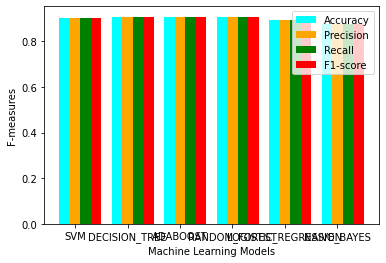

In [79]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# '6' means 6 ML models performance are going to be shown
x = np.arange(6)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, accuracies, width, color='cyan')
plt.bar(x, precisions, width, color='orange')
plt.bar(x+0.2, recalls, width, color='green')
plt.bar(x+0.4, f1_scores, width, color='red')

plt.xticks(x, ['SVM', 'DECISION_TREE', 'ADABOOST', 'RANDOM_FOREST', 'LOGISTIC_REGRESSION','NAIVE_BAYES'])
plt.xlabel("Machine Learning Models")
plt.ylabel("F-measures")
plt.legend(["Accuracy", "Precision", "Recall","F1-score"])
plt.show()

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


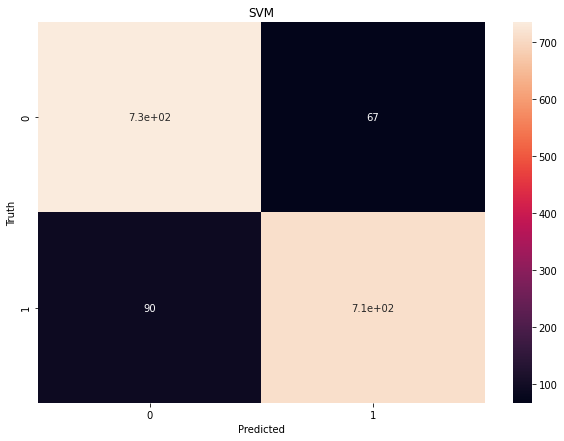

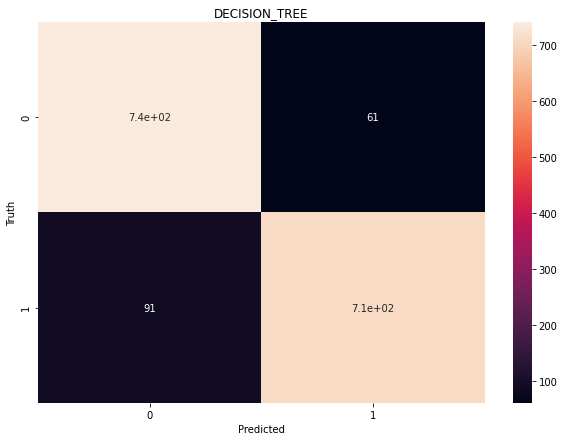

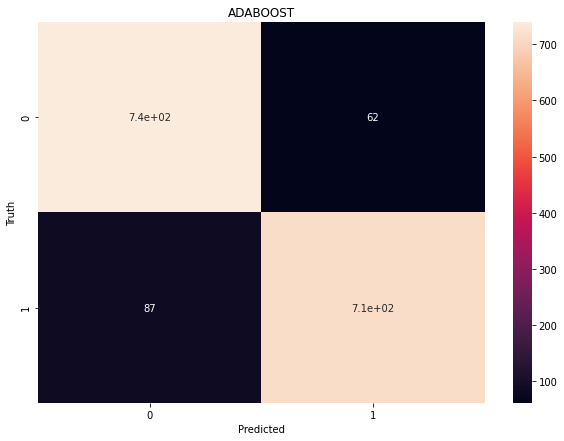

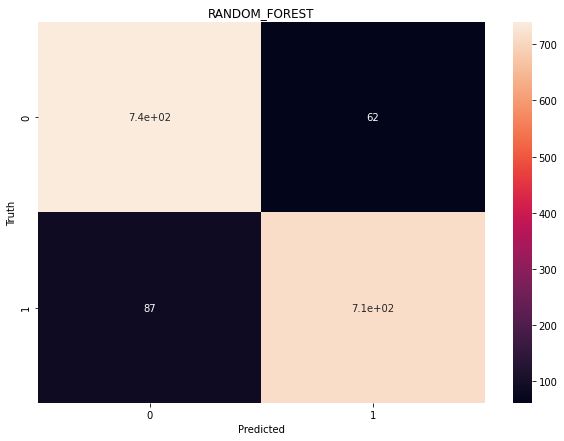

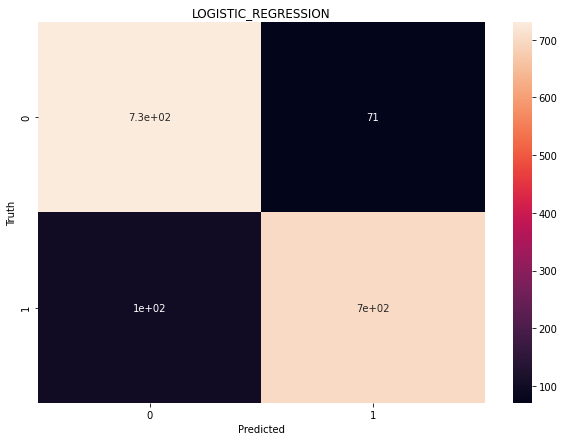

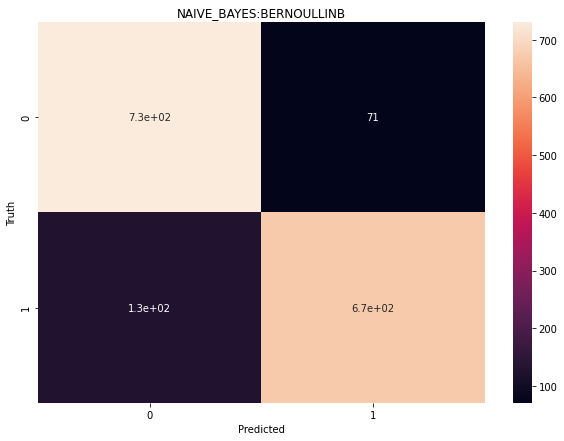

In [81]:
import seaborn as sn
%matplotlib inline
import matplotlib.pyplot as plt

#Confusion matrix of best classification results of the models
for model_name,matrix in ConfusionMatrix.items():
    #print(model_name)
    plt.figure(figsize = (10,7))
    sn.heatmap(matrix, annot=True)
    plt.title(model_name.upper())
    plt.xlabel('Predicted')
    plt.ylabel('Truth')


# TPOT for Automated Machine Learning

##### Reference


*   https://machinelearningmastery.com/tpot-for-automated-machine-learning-in-python/



In [82]:
pip install tpot

     |████████████████████████████████| 92kB 5.4MB/s 
     |████████████████████████████████| 166.7MB 80kB/s 
     |████████████████████████████████| 163kB 45.2MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp37-none-any.whl size=11954 sha256=6e167feab74e92f20c5977ad10a7fa1f5832af9fd4ddbf0a35272fffeba4a746
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [83]:
import tpot
print('tpot: %s' % tpot.__version__)

tpot: 0.11.7


In [84]:
from sklearn.model_selection import RepeatedStratifiedKFold
from tpot import TPOTClassifier
# define model evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
cv

RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=1)

In [85]:
# define search
model = TPOTClassifier(generations=5, population_size=50, cv=cv, scoring='accuracy', verbosity=2, random_state=1, n_jobs=-1)

In [ ]:
# perform the search
model.fit(X, Y)
# export the best model
model.export('tpot_sonar_best_model.py')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Generation 1 - Current best internal CV score: 0.9044888716356106
